## Import Libraries

In [2]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
)


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import pickle

In [3]:
# Collecting Training and Testing Dataset File Paths

dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk("./cicddos2019/"):
    for filename in filenames:
        if filename.endswith("-training.parquet"):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith("-testing.parquet"):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

./cicddos2019/MSSQL-training.parquet
./cicddos2019/UDPLag-training.parquet
./cicddos2019/MSSQL-testing.parquet
./cicddos2019/Portmap-training.parquet
./cicddos2019/UDP-training.parquet
./cicddos2019/LDAP-testing.parquet
./cicddos2019/Syn-training.parquet
./cicddos2019/SNMP-testing.parquet
./cicddos2019/TFTP-testing.parquet
./cicddos2019/Syn-testing.parquet
./cicddos2019/DNS-testing.parquet
./cicddos2019/NetBIOS-training.parquet
./cicddos2019/LDAP-training.parquet
./cicddos2019/UDP-testing.parquet
./cicddos2019/NTP-testing.parquet
./cicddos2019/NetBIOS-testing.parquet
./cicddos2019/UDPLag-testing.parquet


In [4]:
# Common Prefixes in both lists

train_prefixes = [dfp.split("/")[-1].split("-")[0] for dfp in dfps_train]
test_prefixes = [dfp.split("/")[-1].split("-")[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [
    dfp for dfp in dfps_train if dfp.split("/")[-1].split("-")[0] in common_prefixes
]
dfps_test = [
    dfp for dfp in dfps_test if dfp.split("/")[-1].split("-")[0] in common_prefixes
]


In [5]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [6]:
train_df.shape, test_df.shape

((120065, 78), (38973, 78))

In [7]:
train_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,17,47,2,0,928.0,0.0,464.0,464.0,464.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSSQL
1,17,1,2,0,854.0,0.0,427.0,427.0,427.0,0.0,...,834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSSQL
2,17,1,2,0,2370.0,0.0,1185.0,1185.0,1185.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSSQL
3,17,1,2,0,1048.0,0.0,524.0,524.0,524.0,0.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSSQL
4,17,1,2,0,866.0,0.0,433.0,433.0,433.0,0.0,...,472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MSSQL


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120065 entries, 0 to 120064
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  120065 non-null  int8   
 1   Flow Duration             120065 non-null  int32  
 2   Total Fwd Packets         120065 non-null  int32  
 3   Total Backward Packets    120065 non-null  int16  
 4   Fwd Packets Length Total  120065 non-null  float32
 5   Bwd Packets Length Total  120065 non-null  float32
 6   Fwd Packet Length Max     120065 non-null  float32
 7   Fwd Packet Length Min     120065 non-null  float32
 8   Fwd Packet Length Mean    120065 non-null  float32
 9   Fwd Packet Length Std     120065 non-null  float32
 10  Bwd Packet Length Max     120065 non-null  float32
 11  Bwd Packet Length Min     120065 non-null  float32
 12  Bwd Packet Length Mean    120065 non-null  float32
 13  Bwd Packet Length Std     120065 non-null  f

In [9]:
train_df.describe()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,120065.000000,...,120065.000000,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,120065.0,120065.0,120065.0,120065.0
mean,9.847882,2.052619e+07,9.494665,5.229134,793.607483,2.857971e+03,193.468842,124.397636,139.754761,23.783619,...,5.671170,-1.248534e+07,7.801129e+04,7.839450e+04,1.821768e+05,3.275870e+04,6264209.5,1559991.5,7932698.5,4813855.0
std,5.306882,2.995552e+07,356.316717,46.543910,2773.197998,7.461836e+04,362.685333,250.985748,255.343307,89.581734,...,19.933391,1.145488e+08,4.511411e+05,3.852113e+05,8.235641e+05,3.747179e+05,10536990.0,3190672.0,12437144.0,9490018.0
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
25%,6.000000,4.110000e+02,2.000000,0.000000,36.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
50%,6.000000,1.096240e+05,4.000000,2.000000,72.000000,1.200000e+01,6.000000,6.000000,6.000000,0.000000,...,3.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0
75%,17.000000,4.531427e+07,10.000000,4.000000,1076.000000,3.600000e+01,388.000000,52.000000,262.511108,7.905694,...,7.000000,2.000000e+01,3.766667e+01,3.323402e+01,1.010000e+02,1.000000e+00,12203672.0,2413746.5,15799887.0,7754443.0
max,17.000000,1.199975e+08,86666.000000,8029.000000,208524.000000,1.289243e+07,3625.000000,2131.000000,2131.000000,1448.583008,...,3888.000000,6.724045e+07,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,69614024.0,117569200.0,117569200.0


## Data Preprocessing

In [10]:
# Check the target distribution of the training data
train_df["Label"].value_counts()

Label
Syn        48840
Benign     42007
UDP        18090
MSSQL       8523
LDAP        1906
NetBIOS      644
UDPLag        55
Name: count, dtype: int64

In [11]:
# Check the target distribution of the testing data
test_df["Label"].value_counts()

Label
Benign           10847
DrDoS_UDP        10420
UDP-lag           8872
DrDoS_MSSQL       6212
DrDoS_LDAP        1440
DrDoS_NetBIOS      598
Syn                533
WebDDoS             51
Name: count, dtype: int64

The `WebDDoS` label is not present in the training data, so we will not be able to use it for training. We will remove it from the testing data.

In [12]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

The target column values are not matching in the training and testing data. We will replace the target values in the testing data with the values present in the training data.

In [13]:
# Map the labels to the same format
label_mapping = {
    "DrDoS_UDP": "UDP",
    "UDP-lag": "UDPLag",
    "DrDoS_MSSQL": "MSSQL",
    "DrDoS_LDAP": "LDAP",
    "DrDoS_NetBIOS": "NetBIOS",
    "Syn": "Syn",  # Already matches
    "Benign": "Benign",  # Already matches
}

test_df["Label"] = test_df["Label"].map(label_mapping)

In [14]:
# Check the target distribution of the testing data
test_df["Label"].value_counts()

Label
Benign     10847
UDP        10420
UDPLag      8872
MSSQL       6212
LDAP        1440
NetBIOS      598
Syn          533
Name: count, dtype: int64

In [15]:
# Display the columns of the training data
train_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

#### Find the categorical columns, numerical columns, categorical but high cardinality columns.

In [16]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
FIN Flag Count
PSH Flag Count
ECE Flag Count
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate


In [17]:
# Features with a single unique value
single_val_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]

# Remove columns with a single unique value
train_df.drop(single_val_cols, axis=1, inplace=True)
test_df.drop(single_val_cols, axis=1, inplace=True)

# Shape of the dataset after removing columns with a single unique value
train_df.shape, test_df.shape

((120065, 66), (38922, 66))

In [18]:
def grab_col_names(data, cat_th=10, car_th=20):
    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [
        col
        for col in data.columns
        if data[col].nunique() < cat_th and data[col].dtypes != "O"
    ]
    high_card_cat_cols = [
        col
        for col in data.columns
        if data[col].nunique() > car_th and data[col].dtypes == "O"
    ]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols


cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)
print(f"Catergorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

Observations: 120065
Variables: 66
Categorical Columns: 8
Numerical Columns: 58
High Cardinality Categorical Columns: 0
Number but Categorical Columns: 7


Catergorical Columns: ['Label', 'Protocol', 'Fwd PSH Flags', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count']
Numerical Columns: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min',

In [19]:
# Display the unique values of the categorical columns
for i in cat_cols:
    print(i, train_df[i].unique())

Label ['MSSQL' 'LDAP' 'Benign' 'UDP' 'Syn' 'UDPLag' 'NetBIOS']
Protocol [17  0  6]
Fwd PSH Flags [0 1]
SYN Flag Count [0 1]
RST Flag Count [0 1]
ACK Flag Count [0 1]
URG Flag Count [0 1]
CWE Flag Count [0 1]


### Missing Values

In [20]:
# Total number of missing values
print(f"Total number of missing values: {train_df.isnull().sum().sum()}")

Total number of missing values: 0


### Duplicate Rows

In [21]:
print(f"Number of Duplicate Rows: {train_df.duplicated().sum()}")

Number of Duplicate Rows: 3195


In [22]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

# Exploratory Data Analysis (EDA)


### Categorical Columns

         Label      Ratio
Label                    
Syn      47246  40.426114
Benign   40980  35.064602
UDP      17795  15.226320
MSSQL     8434   7.216565
LDAP      1885   1.612903
NetBIOS    475   0.406434
UDPLag      55   0.047061




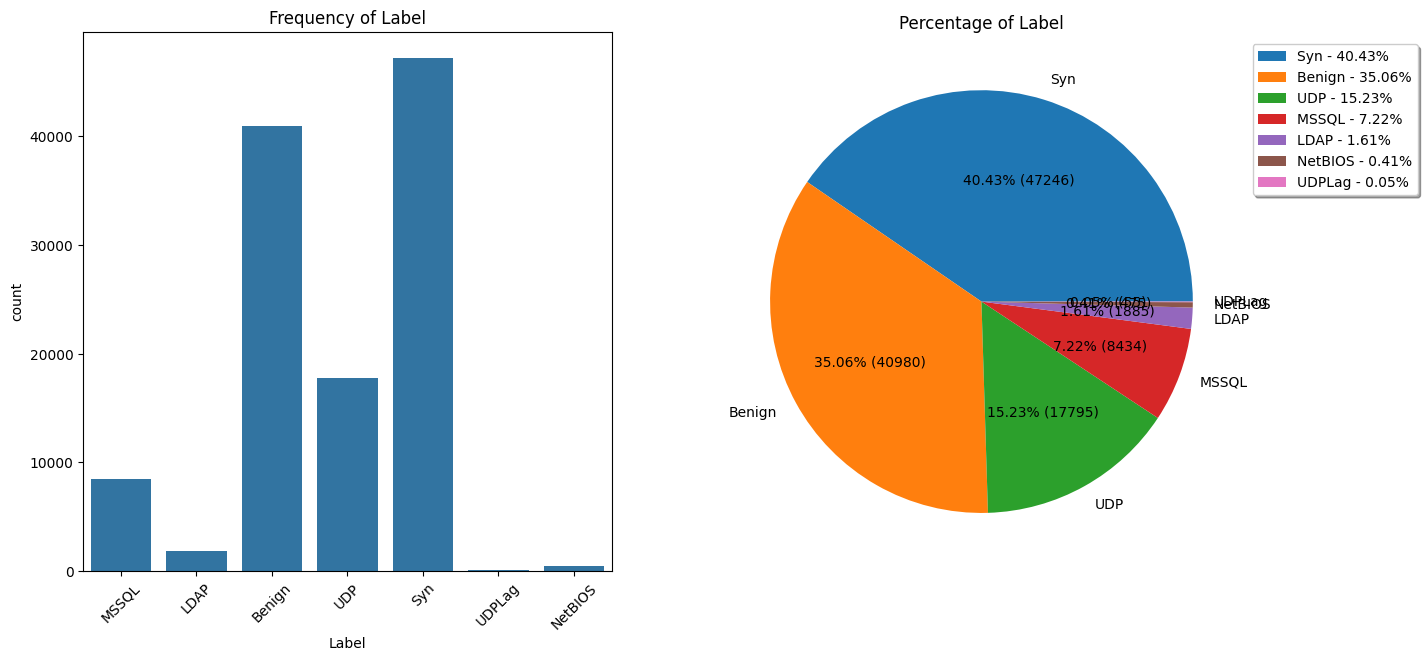

          Protocol      Ratio
Protocol                     
6            74330  63.600582
17           41807  35.772226
0              733   0.627193




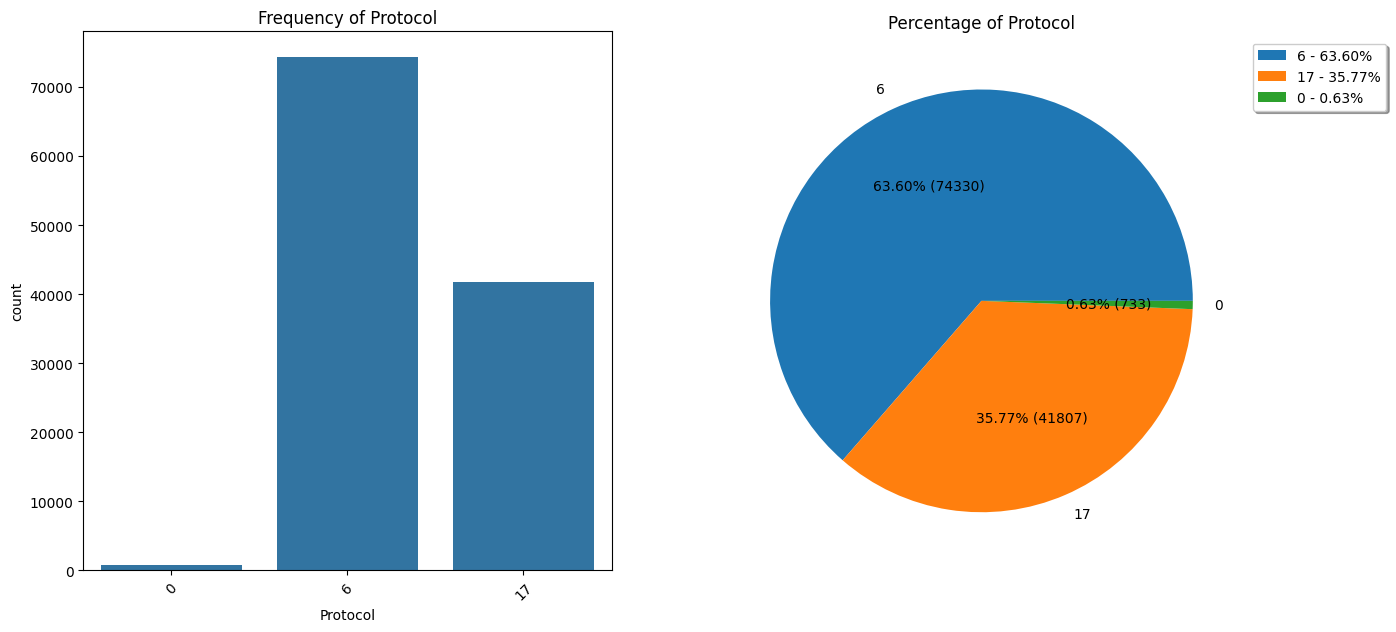

               Fwd PSH Flags      Ratio
Fwd PSH Flags                          
0                     111549  95.447078
1                       5321   4.552922




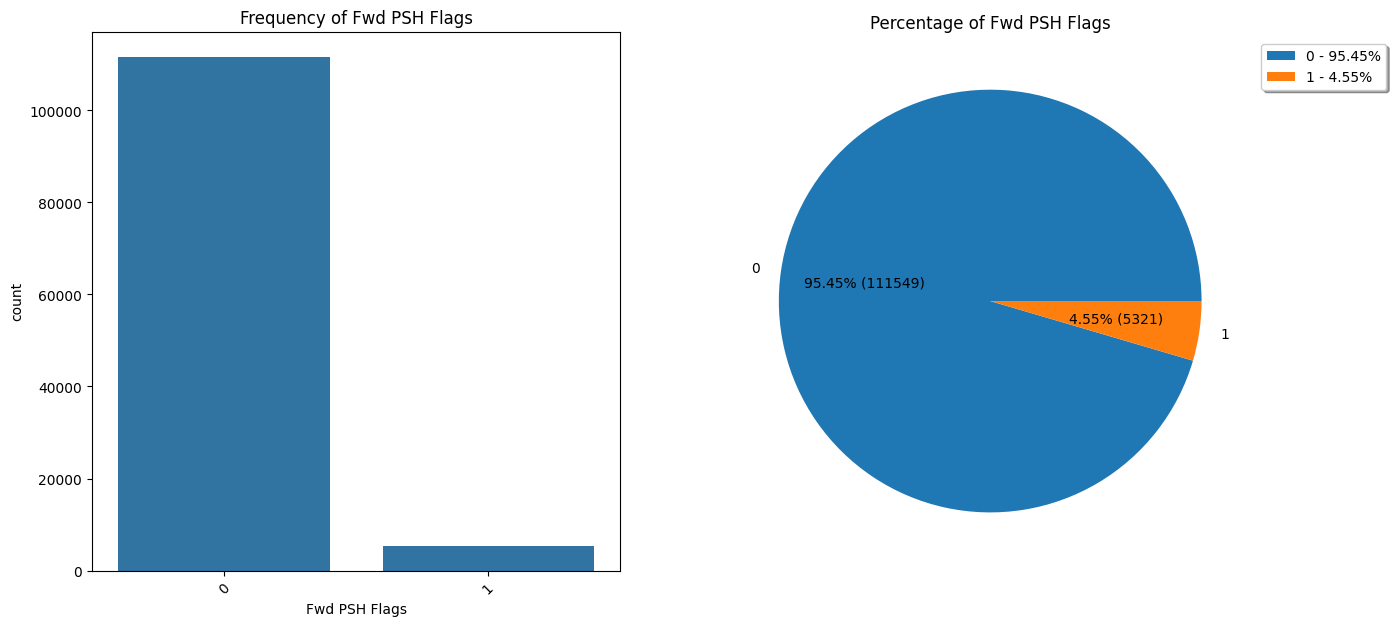

                SYN Flag Count      Ratio
SYN Flag Count                           
0                       116773  99.917002
1                           97   0.082998




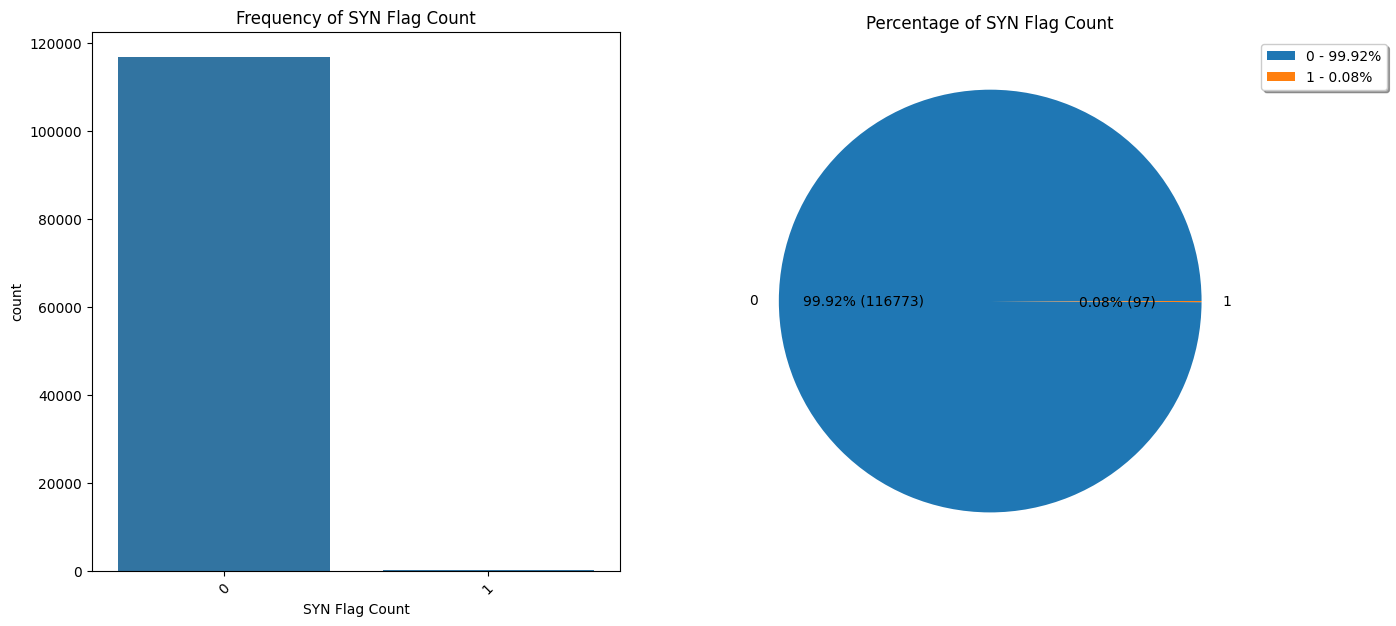

                RST Flag Count      Ratio
RST Flag Count                           
0                       111549  95.447078
1                         5321   4.552922




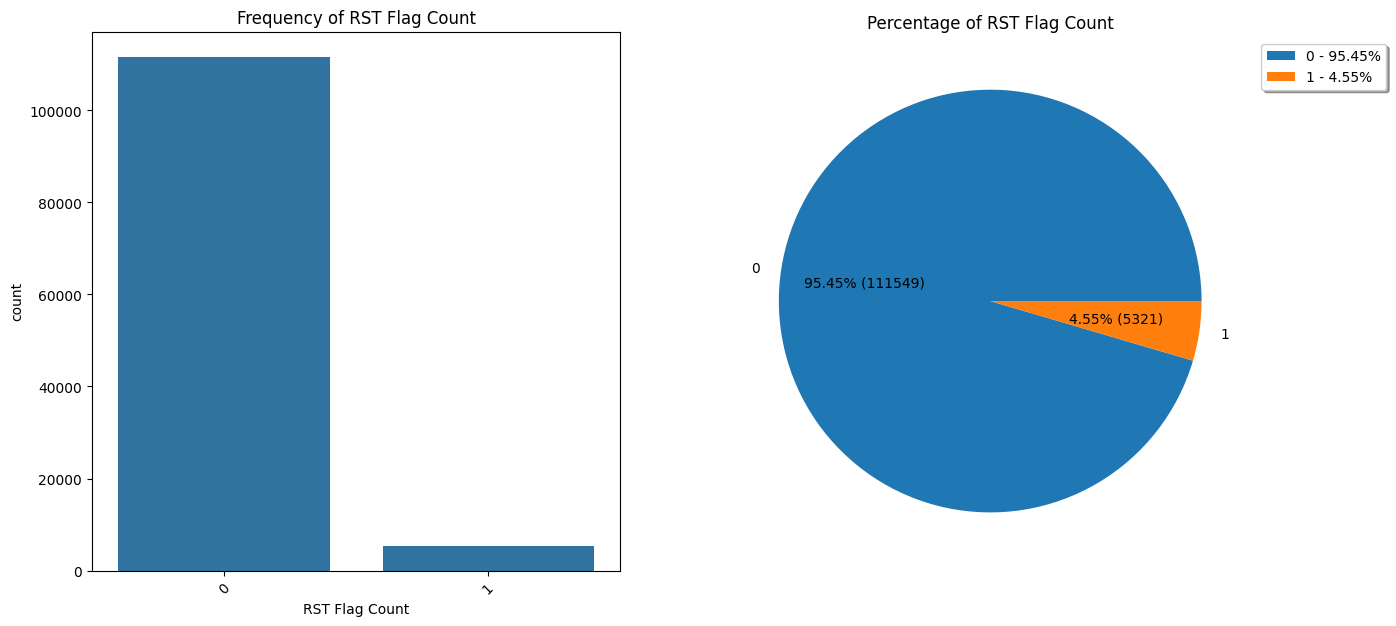

                ACK Flag Count      Ratio
ACK Flag Count                           
0                        60525  51.788312
1                        56345  48.211688




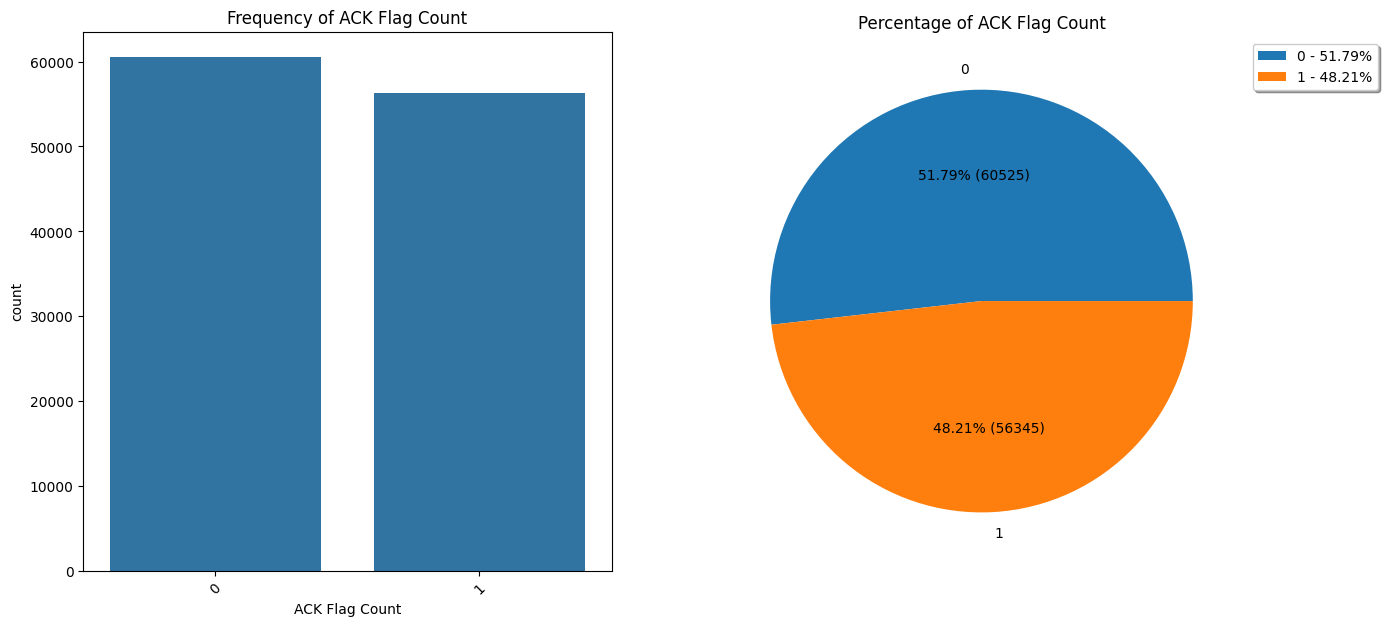

                URG Flag Count      Ratio
URG Flag Count                           
0                        98885  84.611106
1                        17985  15.388894




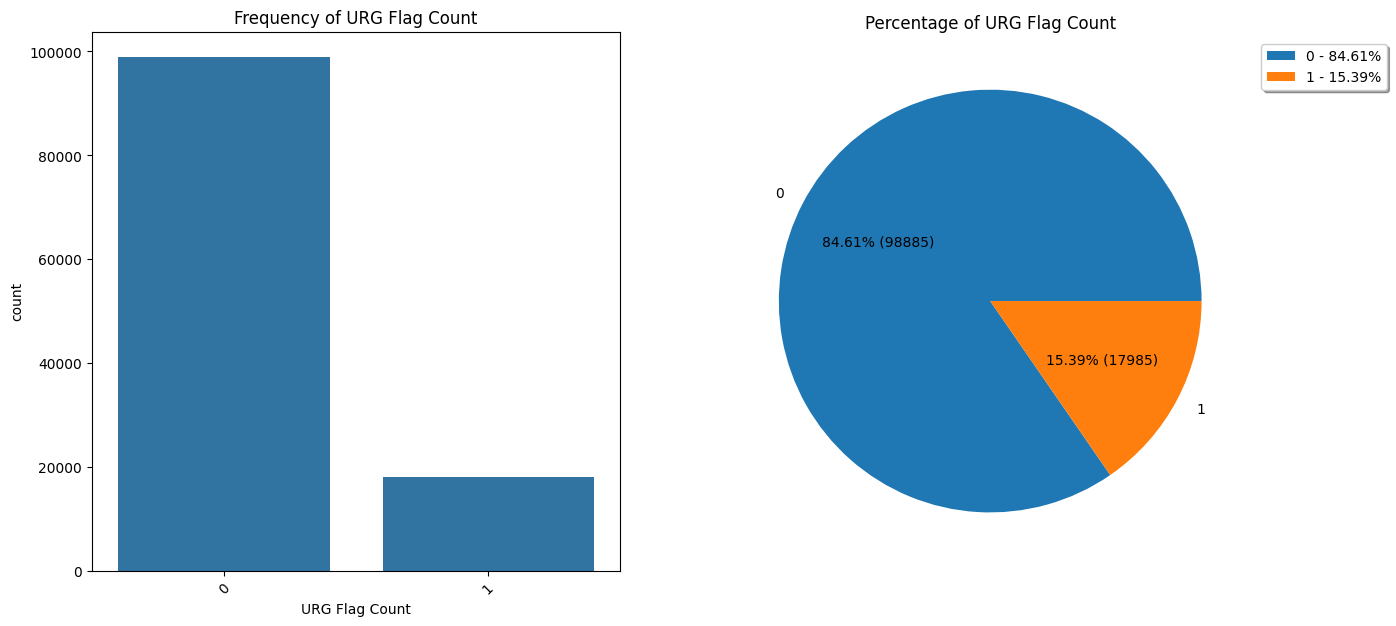

                CWE Flag Count      Ratio
CWE Flag Count                           
0                       107769  92.212715
1                         9101   7.787285




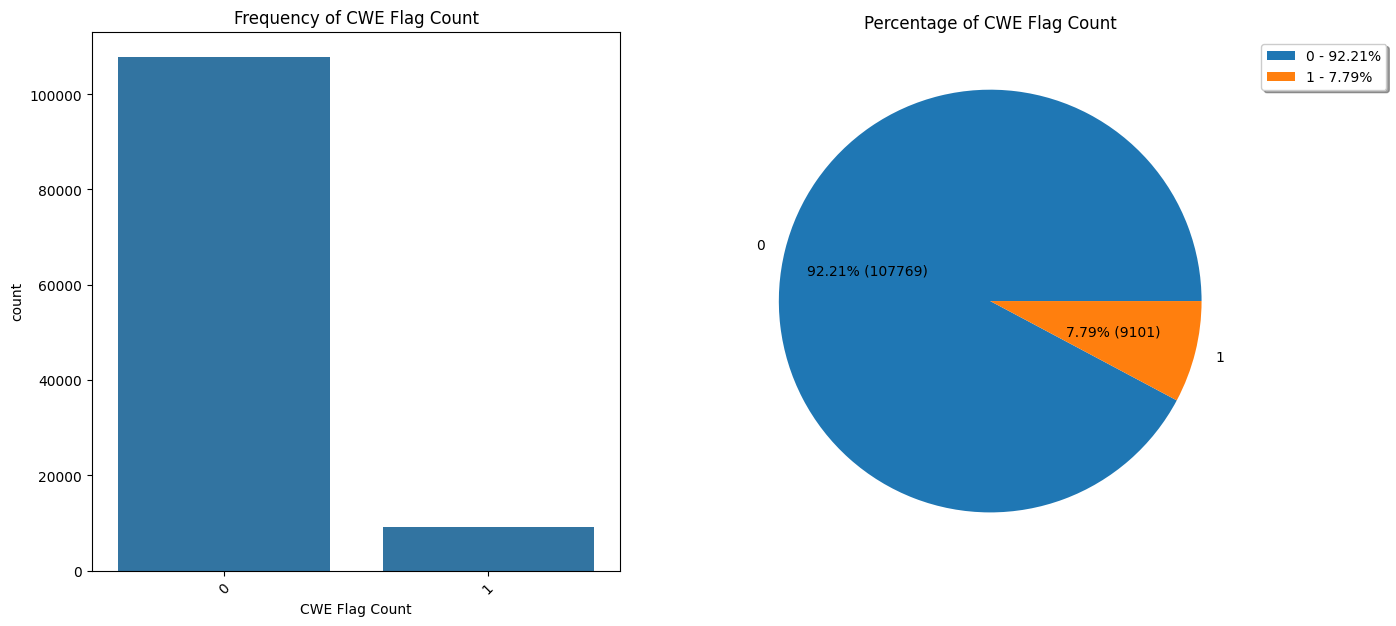

In [23]:
def cat_summary(data, col, plot=False):
    print(
        pd.DataFrame(
            {
                col: data[col].value_counts(),
                "Ratio": data[col].value_counts() / len(data) * 100,
            }
        )
    )
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data=data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(
            x=values,
            labels=values.index,
            autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x / 100 * sum(values)),
        )
        plt.legend(
            labels=[
                "{} - {:.2f}%".format(index, value / sum(values) * 100)
                for index, value in zip(values.index, values)
            ],
            loc="upper left",
            bbox_to_anchor=(1, 1),
            fancybox=True,
            shadow=True,
            ncol=1,
        )
        plt.title(f"Percentage of {col}")
        plt.show(block=True)


for col in cat_cols:
    cat_summary(train_df, col, True)

# Numberical Columns

In [24]:
# Distribution Plots for Numerical Columns


def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")


def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")


def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")


# Relational Plots for Numerical Columns


def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")


def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")


# Categorical Plots for Categorical Columns


def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(
        x=values,
        labels=values.index,
        autopct=lambda x: "{:.2f}% ({:.0f})".format(x, x / 100 * sum(values)),
    )
    ax.legend(
        labels=[
            "{} - {:.2f}%".format(index, value / sum(values) * 100)
            for index, value in zip(values.index, values)
        ],
        loc="upper left",
        bbox_to_anchor=(1, 1),
        fancybox=True,
        shadow=True,
        ncol=1,
    )
    ax.set_title(f"Pie Chart of {col}")


def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)


def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)


def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)


# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size:
        plt.figure(figsize=size)
    sns.heatmap(
        data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12}
    )
    plt.title("Correlation Matrix")
    plt.show()


def my_vsplot(data, normal_col, label_col):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(
        list(dict(data[normal_col].value_counts()).key()),
        dict(data[normal_col].value_counts()).values(),
        color="r",
    )
    plt.bar(
        list(dict(data[normal_col][data[label_col] == 1].value_counts()).keys()),
        dict(data[normal_col][data[label_col] == 1].value_counts()).values().keys(),
        dict(data[normal_col][data[label_col] == 1].value_counts()).values(),
        color="b",
    )

    plt.xlabel(normal_col)
    plt.ylabel("Counts")
    plt.title(f"{normal_col} vs {label_col}")
    plt.show()


def plot_charts_grid_single_feature(data, plot_func, size=(12, 4), n_col=1):
    if len(data.columns) == 0:
        return
    n_rows = len(data.columns) + n_col - 1
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0] * n_col, size[1] * n_rows))
    if len(data.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        plot_func(data, col, axes[i])

    for j in range(i + 1, n_rows * n_col):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


In [25]:
# plot_charts_grid_single_feature(train_df[num_cols], my_histplot, size=(12, 4), n_col=2)

In [26]:
# plot_charts_grid_single_feature(train_df[num_cols], my_boxplot, size=(2, 4), n_col=6)

### Packet Size and Flow Duration Analysis

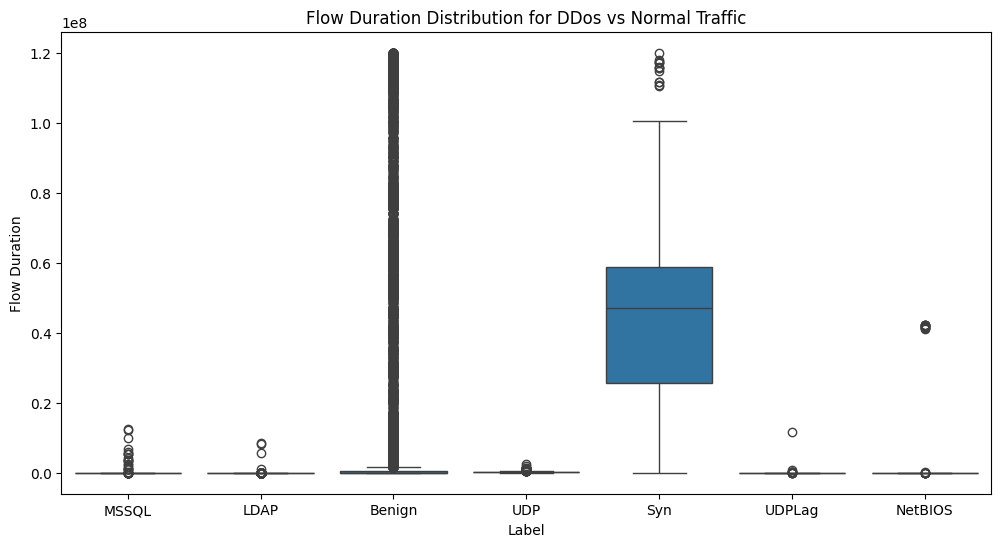

In [27]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=train_df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

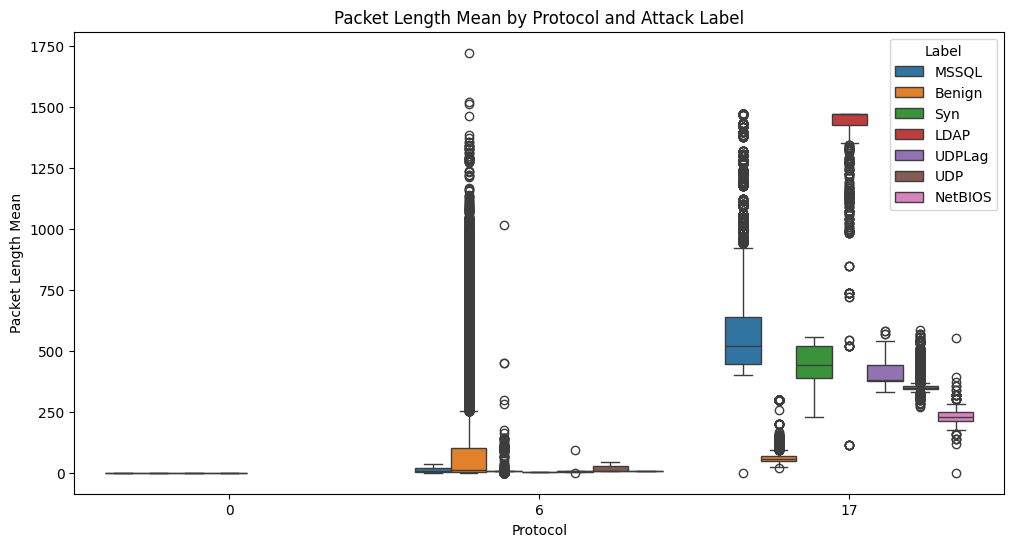

In [28]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=train_df)
plt.title("Packet Length Mean by Protocol and Attack Label")
plt.show()

### Packet Flags and Attack Patterns

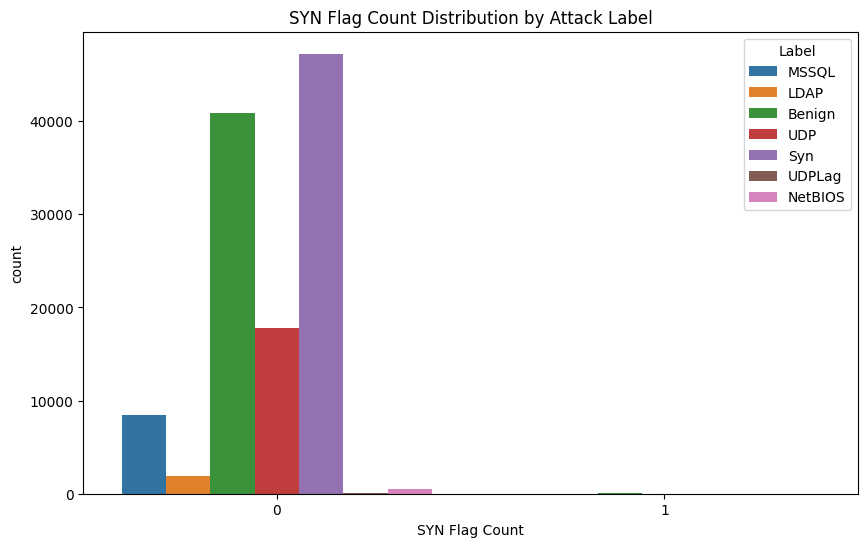

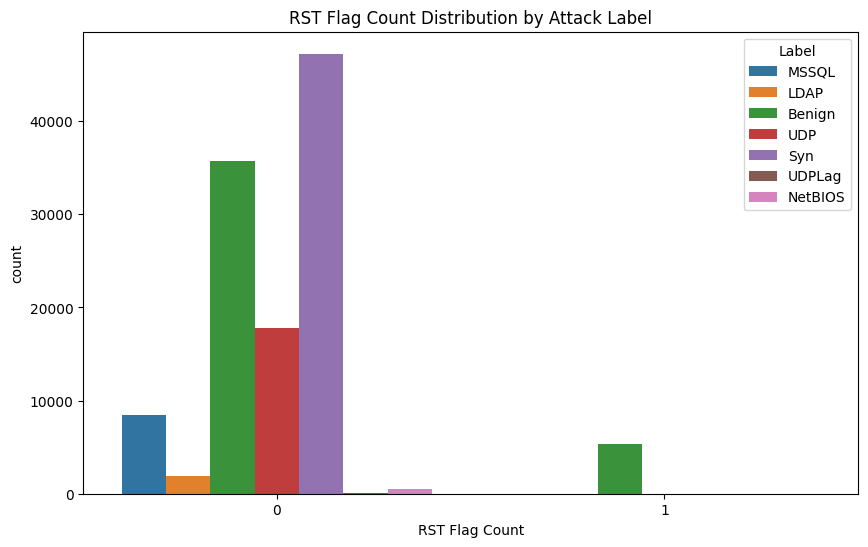

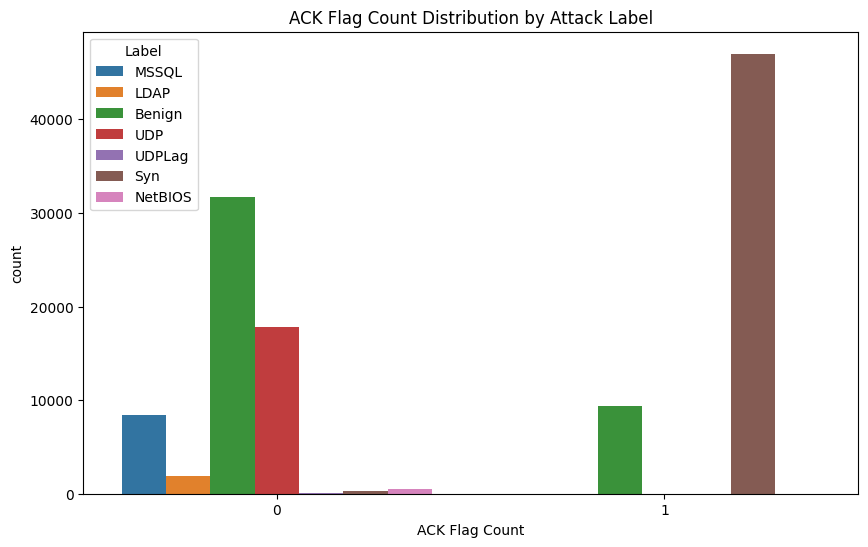

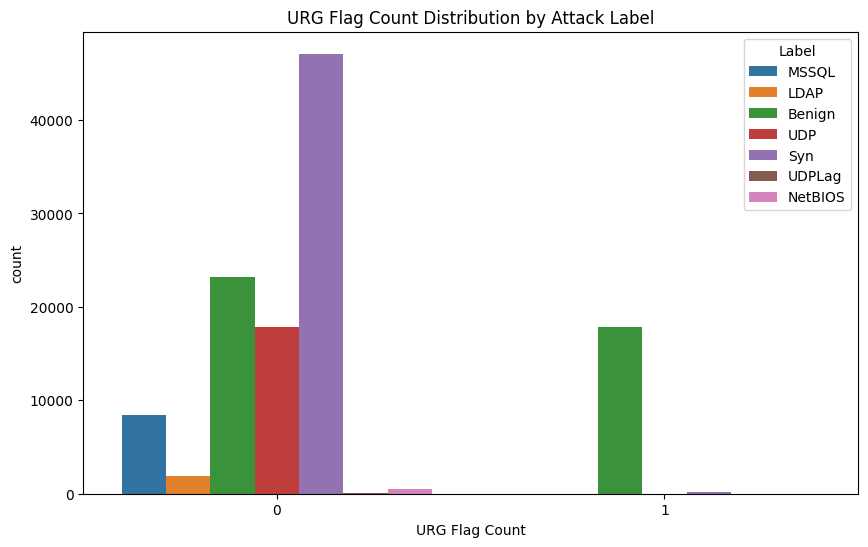

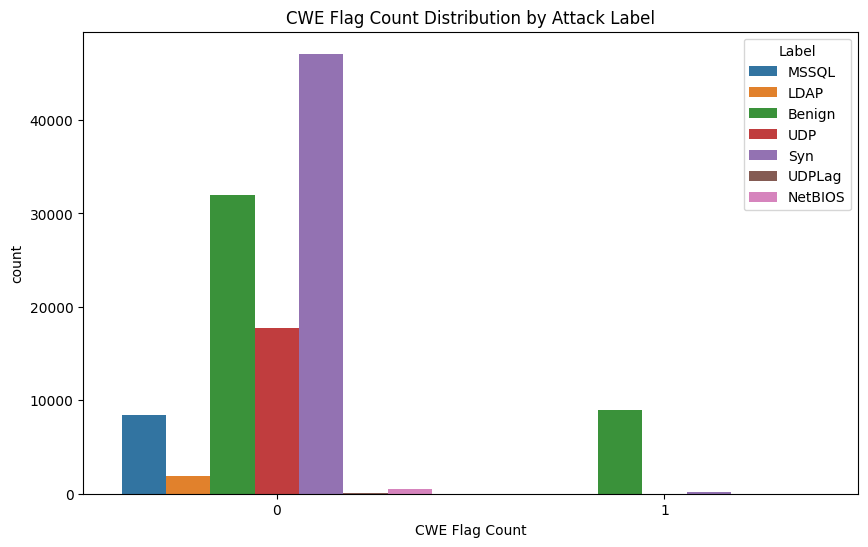

In [29]:
# Counting the number of occurrences of each flag in attack vs normal traffic

flag_cols = [col for col in train_df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=train_df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()

### Requests from Different Protocols

Text(0.5, 1.0, 'The number of requests from different protocols')

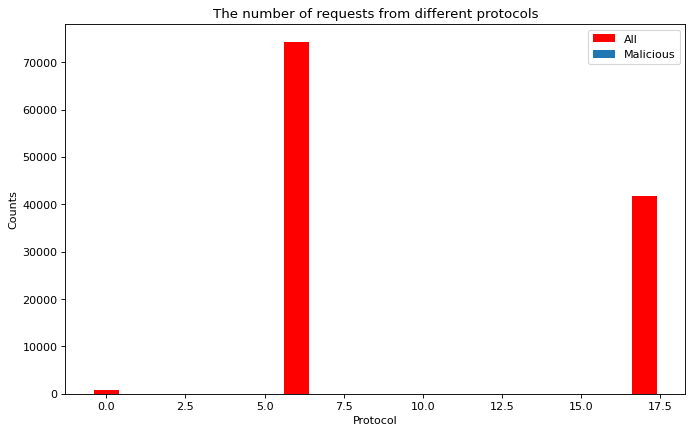

In [30]:
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(
    list(dict(train_df["Protocol"].value_counts()).keys()),
    dict(train_df["Protocol"].value_counts()).values(),
    color="r",
)
plt.bar(
    list(dict(train_df[train_df["Label"] == 1]["Protocol"].value_counts()).keys()),
    dict(train_df[train_df["Label"] == 1]["Protocol"].value_counts()).values(),
    color="b",
)

plt.xlabel("Protocol")
plt.ylabel("Counts")
plt.legend(["All", "Malicious"])
plt.title("The number of requests from different protocols")

### Correlation Matrix

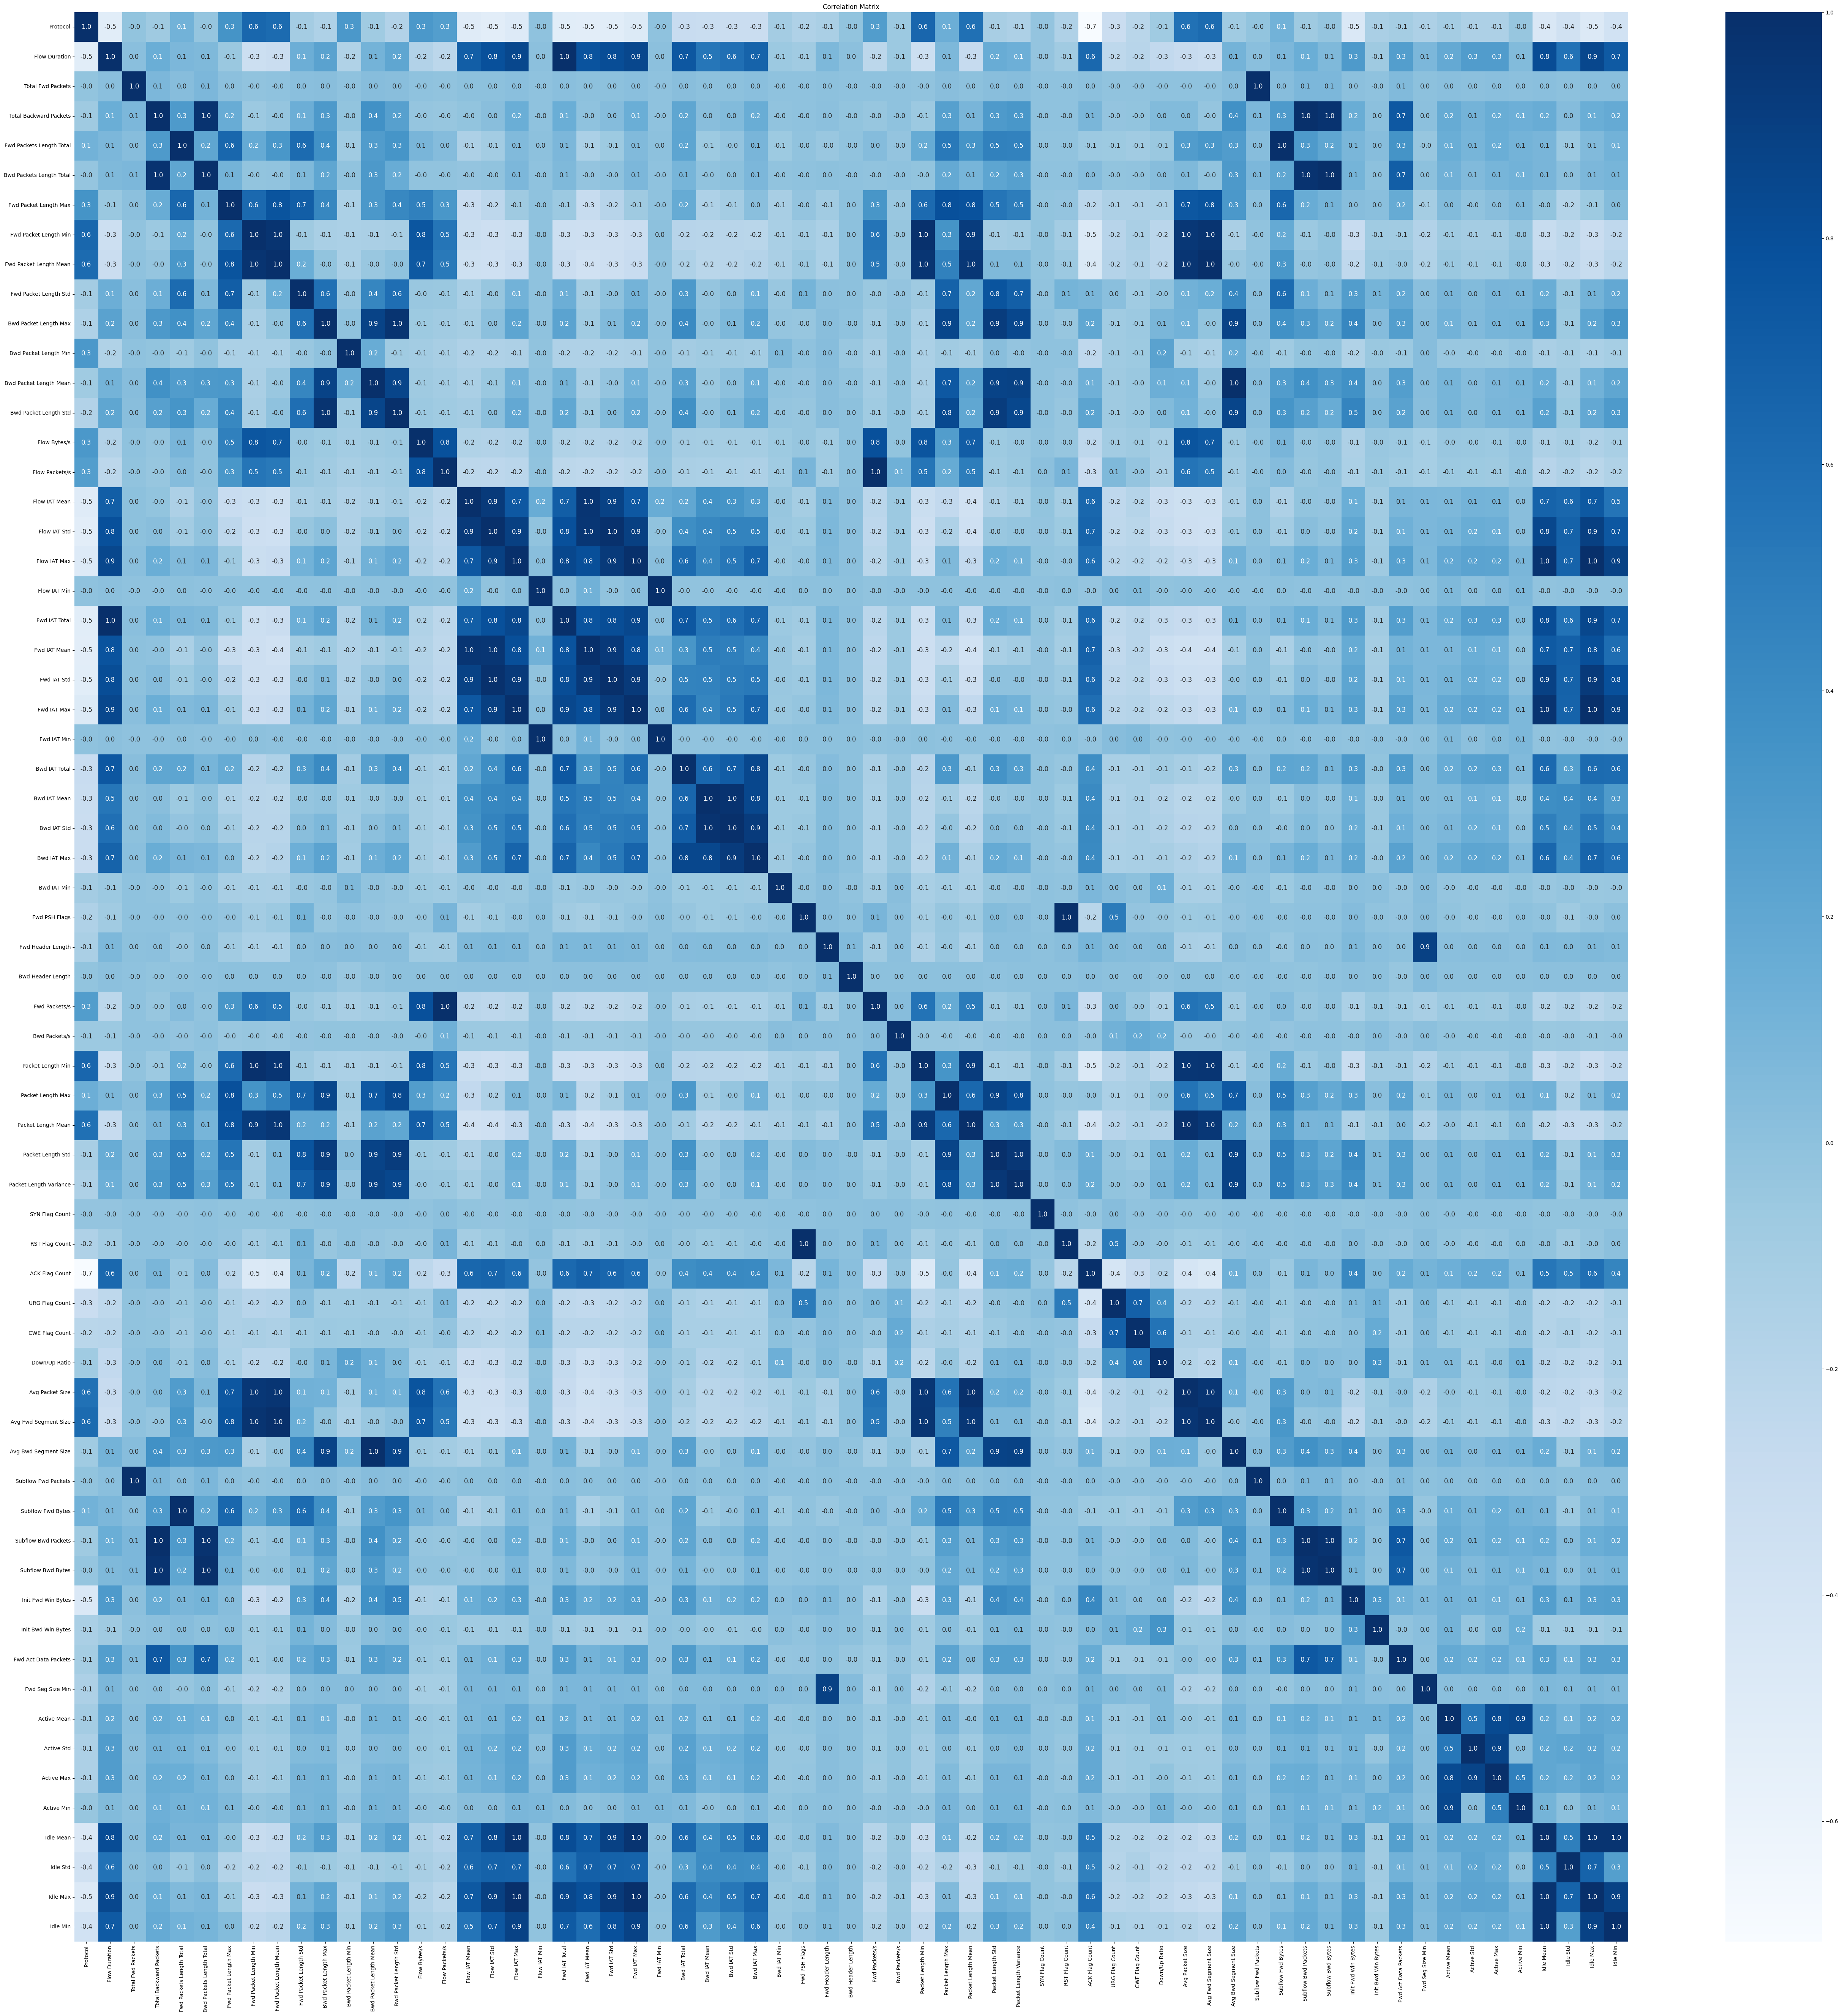

In [31]:
n_numeric_cols = len(train_df.select_dtypes(include=[np.number]).columns)
my_headmap(
    train_df.select_dtypes(include=[np.number]),
    size=(n_numeric_cols + 1, n_numeric_cols + 1),
)

## Future Engineering

### Feature Selection

In [32]:
# Select only numeric columns
numerical_df = train_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [
    col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)
]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

Total number of highly correlated columns: 33
Highly correlated columns are: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [33]:
# Remove highly correlated columns from the dataset
train_df.drop(high_corr_cols, axis=1, inplace=True)
test_df.drop(high_corr_cols, axis=1, inplace=True)

In [34]:
# Shape of the dataset after removing highly correlated columns
train_df.shape, test_df.shape

((116870, 33), (38922, 33))

### Train Test Validation Split

In [35]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42
)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]

In [36]:
X_train.shape, X_val.shape, X_test.shape

((93496, 32), (23374, 32), (38922, 32))

In [37]:
y_train.shape, y_val.shape, y_test.shape

((93496,), (23374,), (38922,))

### Feature Encoding

In [38]:
# Encode the target variable

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [39]:
label_map

{0: 'Benign',
 1: 'LDAP',
 2: 'MSSQL',
 3: 'NetBIOS',
 4: 'Syn',
 5: 'UDP',
 6: 'UDPLag'}

### Feature Scaling

In [40]:
# Feature Scaling using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Model Training and Evaluation


Training Models:   0%|          | 0/5 [00:00<?, ?it/s]

Training Random Forest......


Training Models:  20%|██        | 1/5 [00:22<01:29, 22.47s/it]

Training KNN......


Training Models:  40%|████      | 2/5 [00:25<00:33, 11.19s/it]

Training Extra Trees......


Training Models:  60%|██████    | 3/5 [00:34<00:19,  9.87s/it]

Training MLP Classifier......


Training Models:  80%|████████  | 4/5 [01:23<00:25, 25.31s/it]

Training XGBoost......


Training Models: 100%|██████████| 5/5 [01:32<00:00, 18.51s/it]


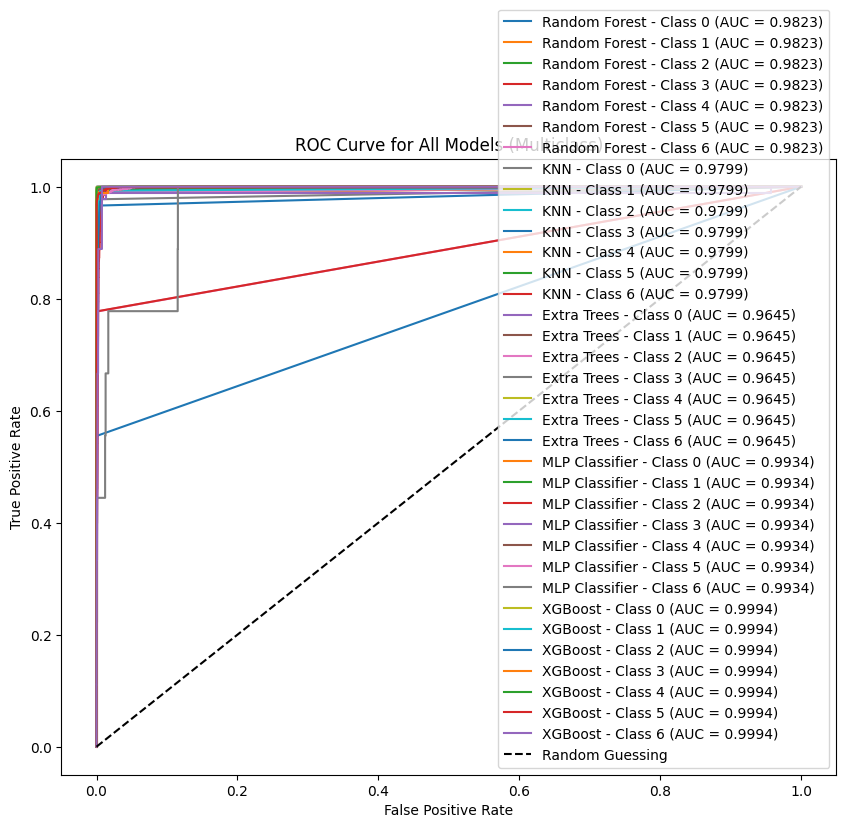

Testing Scores between different models:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,CV Score
0,Random Forest,0.992641,0.992614,0.992641,0.992615,0.982262,0.992716
1,KNN,0.990160,0.990073,0.990160,0.990076,0.979937,0.990235
2,Extra Trees,0.992171,0.992046,0.992171,0.992080,0.964470,0.992556
3,MLP Classifier,0.988748,0.988698,0.988748,0.988657,0.993424,0.988524
4,XGBoost,0.992256,0.992407,0.992256,0.992310,0.999445,0.991540


In [41]:
# Train and evaluate models
def train_model(X_train, X_test, y_train, y_test):
    # Initialize models
    classifiers = {
        "Random Forest": RandomForestClassifier(),
        "KNN": KNeighborsClassifier(n_neighbors=10),
        "Extra Trees": ExtraTreesClassifier(),
        "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
        "XGBoost": XGBClassifier(),
    }

    scores_list = []

    # Initialize plot for ROC curves
    plt.figure(figsize=(10, 8))

    # Train and evaluate models with progress bar
    for name, model in tqdm(classifiers.items(), desc=f"Training Models"):
        print(f"Training {name}......")

        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Evaluate predictions for multiclass
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class="ovr")

        cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=5))

        # ROC curve for the model (for each class)
        y_proba = model.predict_proba(X_test)
        for i in range(len(np.unique(y_train))):
            fpr, tpr, _ = roc_curve(y_test, y_proba[:, i], pos_label=i)
            plt.plot(fpr, tpr, label=f"{name} - Class {i} (AUC = {roc_auc:.4f})")

        # Append scores to the list
        scores_list.append(
            {
                "Model": name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1 Score": f1,
                "ROC AUC": roc_auc,
                "CV Score": cv_score,
            }
        )

    # Finalize the ROC plot
    plt.plot(
        [0, 1], [0, 1], "k--", label="Random Guessing"
    )  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for All Models (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

    # Create and display the DataFrame of scores
    scores = pd.DataFrame(scores_list)
    return scores


# Run the function
scores = train_model(X_train, X_val, y_train, y_val)
print("Testing Scores between different models:")
display(scores.style.background_gradient(cmap="viridis"))

#### Display the Accuracy Score Plot

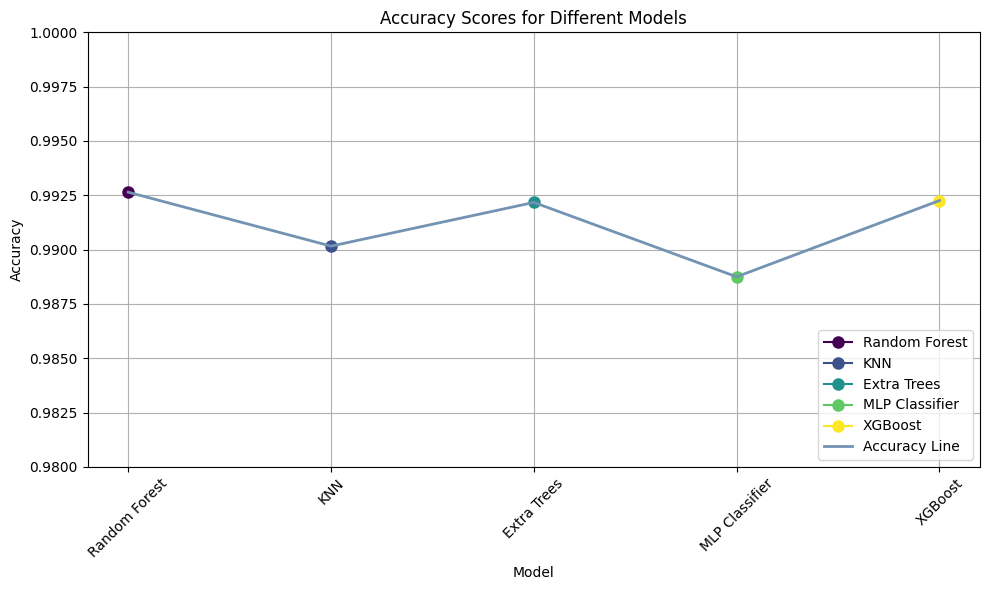

In [42]:
# Assuming 'scores' DataFrame has columns 'Model' and 'Accuracy'
models = scores["Model"]
accuracy = scores["Accuracy"]

# Generate a color map
colors = cm.viridis(np.linspace(0, 1, len(models)))

# Plotting the accuracy points with color for each model
plt.figure(figsize=(10, 6))
for i, (model, acc) in enumerate(zip(models, accuracy)):
    plt.plot(model, acc, marker="o", color=colors[i], markersize=8, label=model)

# Adding a line that passes through the points
plt.plot(
    models, accuracy, linestyle="-", color="#7393B3", linewidth=2, label="Accuracy Line"
)

# Customizing the plot
plt.title("Accuracy Scores for Different Models")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0.98, 1)
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot with legend at the bottom right
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicate labels
plt.legend(unique_labels.values(), unique_labels.keys(), loc="lower right")

# Show the plot
plt.tight_layout()
plt.show()


### Export the Best Model (Random Forest) for Deployment


In [43]:
# Train the best model on the training data
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Save the model to a file using pickle
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("Model saved as 'random_forest_model.pkl'")

Model saved as 'random_forest_model.pkl'


### Recommendation
- **Random Forest** is the best choice for DDoS prediction due to its balanced performance across all metrics.
- **MLP Classifier** can be considered for scenarios prioritizing the ability to distinguish between DDoS and non-DDoS traffic (as indicated by the ROC AUC score).